In [1]:
from pgvector.psycopg import register_vector
import psycopg

In [2]:
conn = psycopg.connect(dbname="retrieval_db", autocommit=True)

register_vector(conn)

In [3]:
conn.execute("SELECT * from image_metadata LIMIT 5;").fetchall()

[(53120,
  'http://images.cocodataset.org/val2014/COCO_val2014_000000053120.jpg',
  'Several horses with riders crossing a body of water.',
  'A group of people is riding horses along a sandy beach near a body of water. The horses are walking in the shallow water, and the riders are wearing blue and red clothing. The beach is surrounded by trees, and there is a wooden post visible in the foreground.',
  '53120.jpg',
  array([-1.19250817e-02, -1.42739089e-02,  2.58339178e-02,  2.77638361e-02,
          8.01595822e-02,  7.76813459e-03, -1.77449472e-02, -2.83767637e-02,
          2.76749078e-02,  4.49392386e-02,  5.27689755e-02, -5.89205921e-02,
         -4.54305392e-03,  2.14999970e-02, -2.99799480e-02, -7.23775337e-03,
         -1.87726971e-02,  5.08540273e-02,  5.13328984e-02,  3.54480147e-02,
         -8.78155157e-02, -1.70766115e-02, -4.36502136e-02,  1.33361416e-02,
          1.40420198e-02,  1.18245771e-02, -3.87900062e-02, -4.38412912e-02,
          1.99008714e-02,  1.03425197e-02

In [4]:
sql = """
WITH semantic_search AS (
    SELECT image_id, image_filepath, RANK () OVER (ORDER BY img_emb <=> %(embedding)s) AS rank
    FROM image_metadata
    ORDER BY img_emb <=> %(embedding)s
    LIMIT 20
),
keyword_search AS (
    SELECT image_id, image_filepath, RANK () OVER (ORDER BY ts_rank_cd(to_tsvector('english', caption), query) DESC)
    FROM image_metadata, plainto_tsquery('english', %(query)s) query
    WHERE to_tsvector('english', caption) @@ query
    ORDER BY ts_rank_cd(to_tsvector('english', caption), query) DESC
    LIMIT 20
)
SELECT
    COALESCE(semantic_search.image_id, keyword_search.image_id) AS id,
    COALESCE(semantic_search.image_filepath, keyword_search.image_filepath) AS image_filepath,
    COALESCE(1.0 / (%(k)s + semantic_search.rank), 0.0) +
    COALESCE(1.0 / (%(k)s + keyword_search.rank), 0.0) AS score
FROM semantic_search
FULL OUTER JOIN keyword_search ON semantic_search.image_id = keyword_search.image_id
ORDER BY score DESC
LIMIT 10
"""

In [5]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# if you have CUDA or MPS, set it to the active device like this
device = (
    "cuda"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

query = "a dog in the snow"

# create transformer-readable tokens
inputs = tokenizer(query, return_tensors="pt").to(device)

# use CLIP to encode tokens into a meaningful embedding
text_emb = model.get_text_features(**inputs)
text_emb = text_emb.cpu().detach().numpy()
text_emb = text_emb.flatten()

In [6]:
text_emb.shape

(512,)

In [7]:
k = 60
results = conn.execute(sql, {"query": query, "embedding": text_emb, "k": k}).fetchall()
for row in results:
    print("document:", row[0], "RRF score:", row[1])

document: 80455 RRF score: 80455.jpg
document: 87070 RRF score: 87070.jpg
document: 8350 RRF score: 8350.jpg
document: 73445 RRF score: 73445.jpg
document: 414481 RRF score: 414481.jpg
document: 474164 RRF score: 474164.jpg
document: 211707 RRF score: 211707.jpg
document: 431058 RRF score: 431058.jpg
document: 51685 RRF score: 51685.jpg
document: 89999 RRF score: 89999.jpg


In [8]:
results

[(80455, '80455.jpg', Decimal('0.01639344262295081967')),
 (87070, '87070.jpg', Decimal('0.01612903225806451613')),
 (8350, '8350.jpg', Decimal('0.01587301587301587302')),
 (73445, '73445.jpg', Decimal('0.01562500000000000000')),
 (414481, '414481.jpg', Decimal('0.01538461538461538462')),
 (474164, '474164.jpg', Decimal('0.01515151515151515152')),
 (211707, '211707.jpg', Decimal('0.01492537313432835821')),
 (431058, '431058.jpg', Decimal('0.01470588235294117647')),
 (51685, '51685.jpg', Decimal('0.01449275362318840580')),
 (89999, '89999.jpg', Decimal('0.01428571428571428571'))]

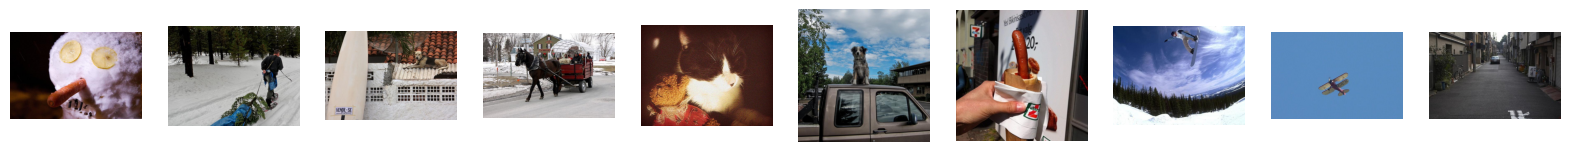

In [12]:
# plot results
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(1, 10, figsize=(20, 20))
for i, row in enumerate(results):
    image_filename = row[1]
    image_filepath = f"../saved_images_coco_30k/{image_filename}"
    img = mpimg.imread(image_filepath)
    axs[i].imshow(img)
    axs[i].axis("off")